## Data Science Regression Project: CarDekho Price Prediction

### Loading Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [2]:
df1 = pd.read_csv('E:\Car Data.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [4]:
df1.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
df1.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [6]:
len(df1.Car_Name.unique())

98

## Feature Engineering

### Label Encoding

In [7]:
cat1 = ['Car_Name','Year']
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
for items in cat1:
    df1[items]=le.fit_transform(df1[items])
df1.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,90,11,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,93,10,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,68,14,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,96,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,92,11,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Creating Dummy Variables

In [8]:
cat2 = df1[['Fuel_Type','Seller_Type','Transmission']]
def dummy(df):
    dum=cat2
    dum=cat2.astype(str)
    dummy = dum.stack().str.get_dummies().sum(level=0)
    dummy = dummy.astype(int)
    df = pd.concat([df,dummy], axis=1)
    df.drop(['Fuel_Type','Seller_Type','Transmission'], axis=1, inplace=True)
    return df
df2 = dummy(df1)
df2.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Automatic,CNG,Dealer,Diesel,Individual,Manual,Petrol
0,90,11,3.35,5.59,27000,0,0,0,1,0,0,1,1
1,93,10,4.75,9.54,43000,0,0,0,1,1,0,1,0
2,68,14,7.25,9.85,6900,0,0,0,1,0,0,1,1
3,96,8,2.85,4.15,5200,0,0,0,1,0,0,1,1
4,92,11,4.60,6.87,42450,0,0,0,1,1,0,1,0


## Transforming the column with greater values to reduce the complexcity

In [9]:
df2['Kms_Driven'] = np.sqrt(df2['Kms_Driven'])
df2.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Automatic,CNG,Dealer,Diesel,Individual,Manual,Petrol
0,90,11,3.35,5.59,164.316767,0,0,0,1,0,0,1,1
1,93,10,4.75,9.54,207.364414,0,0,0,1,1,0,1,0
2,68,14,7.25,9.85,83.066239,0,0,0,1,0,0,1,1
3,96,8,2.85,4.15,72.111026,0,0,0,1,0,0,1,1
4,92,11,4.60,6.87,206.033978,0,0,0,1,1,0,1,0


In [10]:
y = df2['Selling_Price'].values
df3 = df2.drop(columns=['Selling_Price'])
x = df3.values

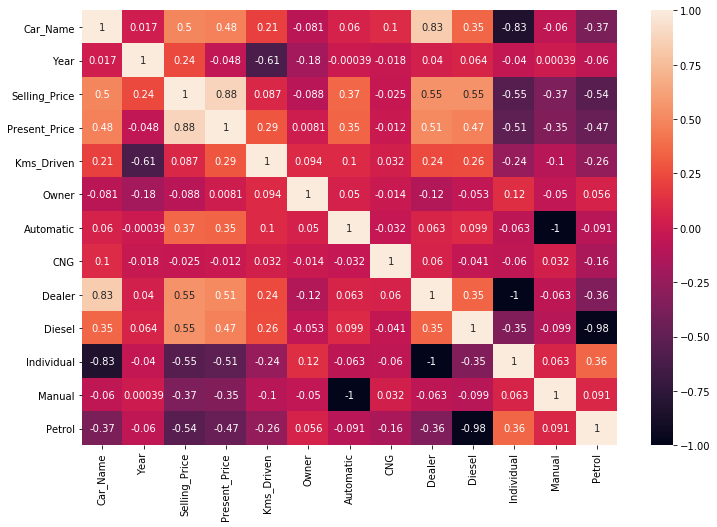

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(df2.corr(), annot=True)

### Defining Metric

In [12]:
def RMSE(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
rmse = make_scorer(RMSE, greater_is_better=False)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
          x, y, test_size=0.2, random_state=42)

### Hyperparameter tuning of ExtremeGradientBoosting Regressor using Bayesian optimization

In [14]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, target):
    estimator = XGBRegressor(
            n_estimators=n_estimators,
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [15]:
def optimize_xgb(data, target):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            target=target,
        )
    optimizer = BayesianOptimization(
            f=xgb_crossval,
            pbounds={
                "n_estimators":(100,550),
                "max_depth": (1,20),
                "gamma":(0,10),
                "min_child_weight":(0,10),
                "subsample":(0.8,1.0)
                },
            random_state=1234,
            verbose=2
      )
    optimizer.maximize(n_iter=15 , init_points=10)
    
    
    print('Final Result:', optimizer.max)

In [16]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(X_train, y_train)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.731    |  1.915    |  12.82    |  4.377    |  453.4    |  0.956    |
|  2        | -1.957    |  2.726    |  6.253    |  8.019    |  531.2    |  0.9752   |
|  3        | -1.676    |  3.578    |  10.52    |  6.835    |  420.7    |  0.8741   |
|  4        | -1.559    |  5.612    |  10.56    |  0.1377   |  447.8    |  0.9765   |
|  5        | -1.493    |  3.649    |  12.69    |  0.7538   |  266.0    |  0.9866   |
|  6        | -1.726    |  6.514    |  8.547    |  7.887    |  242.6    |  0.9136   |
|  7        | -1.901    |  8.691    |  9.287    |  8.021    |  164.7    |  0.9409   |
|  8        | -1.992    |  7.046    |  5.157    |  9.249    |  299.0    |  0.9819   |
|  9        | -1.538    |  0.5981   |  4.501    |  0.4736   |  403.7    |  0.9189   |
|  10       | -1.639    |  

### Hyperparameter tuning of ExtraTreesRegressor using Bayesian optimization

In [17]:
def etc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = ExtraTreesRegressor(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=2,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [18]:
def optimize_etc(data, target):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
                n_estimators=int(n_estimators),
                min_samples_split=int(min_samples_split),
                max_features=max(min(max_features, 0.999), 1e-3),
                data=data,
                target=target,
                )
    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators":(100,600),
            "min_samples_split":(2,25),
            "max_features": (0.1,0.9)
        },
        random_state=42,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)
    
    print("Final result:", optimizer.max)

In [19]:
print(Colours.yellow("--- Optimizing Extra Trees ---"))
optimize_etc(X_train, y_train)

--- Optimizing Extra Trees ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -2.382    |  0.3996   |  23.87    |  466.0    |
|  2        | -1.965    |  0.5789   |  5.588    |  178.0    |
|  3        | -2.649    |  0.1465   |  21.92    |  400.6    |
|  4        | -1.903    |  0.6665   |  2.473    |  585.0    |
|  5        | -1.939    |  0.766    |  6.884    |  190.9    |
|  6        | -2.187    |  0.2467   |  8.998    |  362.4    |
|  7        | -2.094    |  0.4456   |  8.698    |  405.9    |
|  8        | -2.204    |  0.2116   |  8.719    |  283.2    |
|  9        | -2.33     |  0.4649   |  20.06    |  199.8    |
|  10       | -2.135    |  0.5114   |  15.63    |  123.2    |
|  11       | -2.121    |  0.196    |  6.662    |  184.8    |
|  12       | -1.913    |  0.7926   |  6.263    |  587.3    |
|  13       | -2.02     |  0.557    |  7.644    |  580.1    |
|  14       | -1.851    |  0.9      |  

### Hyperparameter tuning of RandomForestRegressor using Bayesian optimization

In [20]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = RandomForestRegressor(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring=rmse, cv=5)
    
    return cval.mean()

In [21]:
def optimize_rfc(data, target):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.9), 1e-3),
            data=data,
            target=target,
            )
    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators":(100,600),
            "min_samples_split":(2,25),
            "max_features":(0.1,0.9),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=20, init_points=10)
    
    print("Final result:", optimizer.max)

In [22]:
print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(X_train, y_train)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -2.358    |  0.2532   |  16.31    |  318.9    |
|  2        | -2.322    |  0.7283   |  19.94    |  236.3    |
|  3        | -2.508    |  0.3212   |  20.44    |  579.1    |
|  4        | -2.124    |  0.8007   |  10.23    |  350.5    |
|  5        | -2.283    |  0.6468   |  18.39    |  285.1    |
|  6        | -2.204    |  0.549    |  13.57    |  106.9    |
|  7        | -2.347    |  0.7183   |  22.3     |  282.4    |
|  8        | -1.737    |  0.5923   |  3.734    |  284.4    |
|  9        | -2.269    |  0.8465   |  16.98    |  298.6    |
|  10       | -2.069    |  0.731    |  9.287    |  384.0    |
|  11       | -2.084    |  0.1      |  2.0      |  278.2    |
|  12       | -1.709    |  0.7487   |  2.324    |  288.4    |
|  13       | -2.049    |  0.3921   |  6.813    |  290.2    |
|  14       | -1.815    |  0.4716   |

### Hyperparameter tuning of ExtremeGradient&RandomForest Regressor using Bayesian optimization

In [23]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFRegressor(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmse, cv=5)
    return cval.mean()

In [24]:
def optimize_xgbrf(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (100, 550),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=10)

    print("Final result:", optimizer.max)

In [25]:
print(Colours.red("--- Optimizing XGBoost RandomForest ---"))
optimize_xgbrf(X_train,y_train)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.232    |  1.915    |  11.6     |  4.377    |  453.4    |  0.956    |
|  2        | -2.591    |  2.726    |  8.488    |  8.019    |  531.2    |  0.9752   |
|  3        | -2.397    |  3.578    |  10.51    |  6.835    |  420.7    |  0.8741   |
|  4        | -1.737    |  5.612    |  10.53    |  0.1377   |  447.8    |  0.9765   |
|  5        | -1.725    |  3.649    |  11.54    |  0.7538   |  266.0    |  0.9866   |
|  6        | -2.494    |  6.514    |  9.575    |  7.887    |  242.6    |  0.9136   |
|  7        | -2.557    |  8.691    |  9.926    |  8.021    |  164.7    |  0.9409   |
|  8        | -2.6      |  7.046    |  7.969    |  9.249    |  299.0    |  0.9819   |
|  9        | -1.636    |  0.5981   |  7.659    |  0.4736   |  403.7    |  0.9189   |
|  10       | 

In [36]:
xgb = XGBRegressor(n_estimators = int(402.578338283996),
                  subsample=0.8668825905278301,
                  min_child_weight=0.09168578683501405,
                  max_depth=int(4.854619123092183),
                  gamma=0.4168039906207077,
                  n_jobs = -1, 
                  random_state = 42)

etc = ExtraTreesRegressor(n_estimators = int(196.9926698778067),
                  min_samples_split=2,
                  max_features=0.9, 
                  random_state = 42)

rfc = RandomForestRegressor(n_estimators = int(291.80230164325997),
                  min_samples_split=2,
                  max_features=0.9, 
                  random_state = 42)

xgrf= XGBRFRegressor(n_estimators = int(259.027424023273),
                  subsample=0.8,
                  min_child_weight=0.0,
                  max_depth=int(15.0),
                  gamma=0.0,
                  n_jobs = -1, 
                  random_state = 42)

### Stacking Regressor

In [37]:
from sklearn.ensemble import StackingRegressor
estimators = [('etc', etc), ('rfc', rfc), ('xgb', xgb),('xgbrf', xgrf)]

model = StackingRegressor(estimators=estimators)

In [38]:
scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = rmse)

scores

array([-1.42909013, -2.74459191, -1.16165328, -1.74715778, -1.24085391])

In [39]:
scores.mean()

-1.6646694010491299

### Among accuracies of all the models XGBoost Regressor gives the minimum 'root_mean_squared_error'

### Now Checking the model performance by plotting the learning_curve

In [40]:
from sklearn.model_selection import learning_curve

In [41]:
train_sizes, train_scores, valid_scores = learning_curve(
xgb , X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 10), scoring=rmse, cv=5)

In [42]:
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean valid scores\n\n',pd.Series(valid_scores_mean, index = train_sizes))

Mean training scores

 1      4.768372e-08
23     2.672519e-01
44     2.393551e-01
65     2.310575e-01
86     2.222889e-01
107    2.201654e-01
128    2.342560e-01
149    2.290676e-01
170    2.278867e-01
192    2.302784e-01
dtype: float64

 --------------------

Mean valid scores

 1      6.681067
23     2.521450
44     2.125791
65     1.758323
86     1.877908
107    1.861466
128    1.689428
149    1.593622
170    1.457631
192    1.399777
dtype: float64


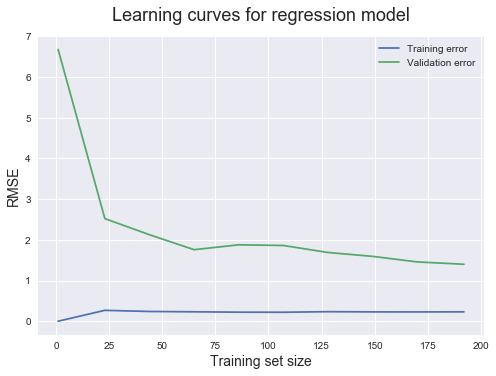

In [43]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for regression model', fontsize = 18, y = 1.03)
plt.legend()

### Limiting the Number of Rows where minimum error has been achieved

In [51]:
train = df2.iloc[:193,:]
test  = df2.iloc[193:,:]
train.tail()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Owner,Automatic,CNG,Dealer,Diesel,Individual,Manual,Petrol
188,21,10,0.25,0.57,134.164079,0,0,0,0,0,1,1,1
189,29,2,0.20,0.57,234.520788,0,0,0,0,0,1,1,1
190,14,5,0.20,0.75,244.948974,0,0,0,0,0,1,1,1
191,10,9,0.20,0.57,158.113883,1,0,0,0,0,1,1,1
192,24,4,0.20,0.75,221.359436,1,0,0,0,0,1,1,1


In [52]:
y1 = train['Selling_Price'].values
d1 = train.drop(columns=['Selling_Price'])
x1 = d1.values
y2 = test['Selling_Price'].values
d2 = test.drop(columns=['Selling_Price'])
x2 = d2.values

### Fitting the Model & Predicting the Values 

In [53]:
model = xgb.fit(x1,y1)

### Calculating metric score to know my model performance on an unseen data

In [54]:
y_pred = model.predict(x2)
r2_score(y2,y_pred)

0.8475974137708194

In [56]:
RMSE(y2,y_pred)

1.1159696083904613